本章考虑约束优化问题：
$$\min f(x),\tag{7.0.1}\\
    s.t.\quad x\in \mathcal{X}$$
这里的$\mathcal{X}$是问题的可行域. 与无约束问题不同, 约束问题中的自变量x不能去任意值. 例如梯度算法中沿着负梯度方向下降的点不一定是在问题的可行域中, 要寻找的最优解处目标函数的梯度也不是零向量.
### 等式约束的二次罚函数法


当我们考虑的问题约束中仅包含等式约束：
$$
\min_{x}f(x), \tag{7.1.1}\\
s.t. \quad c_{i}(x)=0,i\in \varepsilon
$$
其中$x\in R^n, \varepsilon$为等式约束的指标集, $c_i(x)$为连续函数.
#### 定义（等式约束的二次罚函数）
对等式约束最优化问题(7.1.1), 定义二次罚函数为
$$P_E(x,\sigma)=f(x)+\frac{1}{2}\sigma\sum_{i\in\varepsilon}c_{i}^2(x)$$
其中等式右端第二项称为惩罚项, $\sigma>0$称为惩罚因子.
直观上可以这样理解：

对于非可行点而言, 会有$\frac{1}{2}\sigma\sum_{i\in\varepsilon}c_{i}^2(x)$的出现导致罚函数变大，从而对罚函数取极小值是迫使我们找的的点满足$c_{i}(x)=0$

![](1.png)

解释一下$argmin_{x}$：

(1)$x^{k+1}$是罚函数$P_E(x,\sigma_{k})$的全局最小解

(2)$x^{k+1}$是罚函数$P_E(x,\sigma_{k})$的局部最小解

(3)$x^{k+1}$不是罚函数$P_E(x,\sigma_{k})$严格的极小解, 但近似满足一阶最优性条件$\nabla_{x}P_{E}(x^{k+1},\sigma_{k})\approx 0$


### 一般约束问题的二次罚函数法

不等式约束问题有如下形式：
$$
\min\quad f(x),\\
s.t.\quad c_{i}(x)\leq 0,i\in\mathcal{I}
$$

#### 不等式约束的二次罚函数
对不等式约束问题(7.1.12)定义二次罚函数
$$
P_{I}(x,\sigma)=f(x)+\frac{1}{2}\sigma\sum_{i\in\mathcal{I}}\bar{c}_{i}^2(x)
$$
其中等式右端第二项称为惩罚项,
$$
\bar{c}_{i}(x)=\max\{c_{i}(x),0\}
$$

#### 罚函数的思想
对于有约束问题, 罚函数法的思想是通过约束条件构造一个带系数$\sigma$的惩罚项, 在迭代的初期从一个较小的$\sigma$开始, 此时惩罚项的权重比较小, 这样此时算法的重点是在寻找目标函数的最小值. 随着迭代的进行, $\sigma$会逐步变大, 此时约束项的作用便会体现出来, 此时算法更注重得到的解是否在可行域的范围内.

### 应用举例
基追踪问题：
$$
\min\quad||x_1||,\\
s.t. \quad Ax = b
$$

使用二次罚函数, 我们可以得到：
$$
\min_{x} \quad ||x||_1+\frac{\sigma}{2}||Ax-b||^2
$$
令LASSO问题的正则化参数$\mu=\frac{1}{\sigma}$, 容易看出此时就等价于LASSO问题：
$$
\min_{x} \quad \frac{1}{2}||Ax-b||^2+\mu||x||_1
$$

![](2.png)

在求解罚函数子问题$arg\min_{x}\{\frac{1}{2}||Ax-b||^2+\mu_{k}||x||_1\}$, 可以采取之前介绍过的次梯度法

In [1]:
import numpy as np
import matplotlib.pyplot as plt

m = 10
n = 5
A = np.random.randint(1,10, (m,n))
b = np.random.randint(1,10, m)
mu_end = 10**(-3)

f = lambda x, mu: (1/2) * np.dot((A@x-b), (A@x-b)) + mu * np.max(x)

grad_f = lambda x, mu: np.transpose(A)@(A@x - b) + mu * np.sign(x)

In [68]:
class LASSO:
    def __init__(self, f, grad_f, step) -> None:
        self.f = f
        self.grad_f = grad_f
        self.step = step

    def subgradient_method(self, x, mu, step = None):
        alpha = 0.0002
        result = self.f(x, mu_end)
        for i in range(step):
            x -= alpha * self.grad_f(x, mu)
            result = np.append(result, self.f(x, mu_end))
        return x, result
    def penalty_method(self):
        x = np.linspace(1, 10, n)
        mu_k = 10
        gamma = 0.1
        result = self.f(x, mu_end)
        while(mu_k > mu_end):
            ##以x^k为初值, 求解 x^{k+1} = argmin{1/2 * ||Ax-b||^2 + mu_k * ||x||_1} 对于这个子问题, 采取之前介绍的次梯度法
            X = self.subgradient_method(x, mu_k, self.step)
            x = X[0]
            result = np.append(result, X[1])
            if (mu_k == mu_end):
                return x, result
            else:
                mu_k = mu_k*gamma
        return x, result
    def directly_subgradient(self):
        x = np.linspace(1, 10, n)
        return self.subgradient_method(x, mu_end, self.step)  

In [69]:
r = LASSO(f, grad_f, 500)

In [70]:
penalty_method = r.penalty_method()
directly_subgradient = r.directly_subgradient()

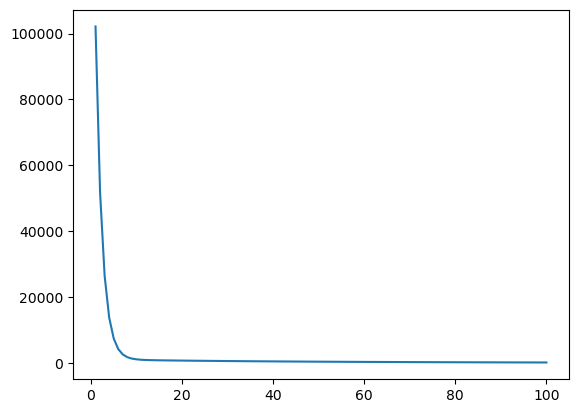

In [86]:
plt.plot(np.linspace(1, 100, 100), directly_subgradient[1][0:100])

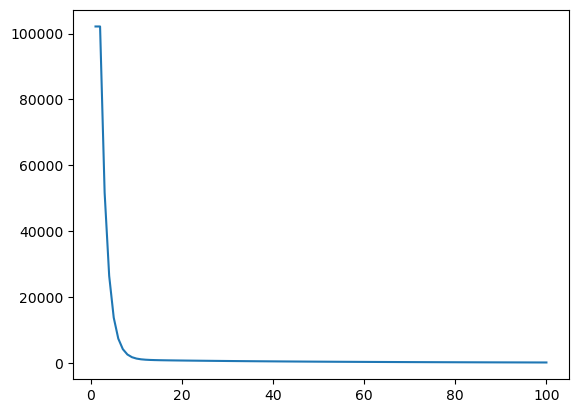

In [87]:
plt.plot(np.linspace(1, 100, 100), penalty_method[1][0:100])

可以看出来, 我们在次梯度方法的基础上使用罚函数的思想可以优化我们的算法。